
# House Prices - Advanced Regression Techniques

In this notebook we will use a dataset provided by **Kaggle** for the competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).  

First we will explore the data and do some basic EDA, and then we will implement both a Random Forest and a neural network model.

Before we start we need to import the resources (libraries, modules, etc.) that we will be using.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import root_mean_squared_error

As the data provided has many features, we will set up **Pandas** to display all columns and rows, making it easier to explore the data.

In [71]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 1. Initial exploration

The data provided by Kaggle has already been separated into train and test datasets, each in a different CSV file.  
Both datasets have the same format, the only difference is our target variable **SalePrice** is missing in the test set.
Along with the data, a file called data_description.txt is provided which contains a description of each column (and of their values in the categorical ones).

We will start by loading the training data and doing some basic exploration to understand what we are dealing with.

In [72]:
trainrawdata_path = '../data/raw/train.csv' # Path to the training dataset
traindf = pd.read_csv(trainrawdata_path)

In [73]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We can see that our training dataset has 1460 datapoints, with 79 features (81 columns but one is **Id** and another is the target variable **SalePrice**).  
There seems to be missing data in some features, which we will explore later.

In [74]:
traindf.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [75]:
traindf.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,

After this first look we see that we have a mixed set of data, some columns are quantitative (numerical) like our target variable **SalePrice** or **LotArea** while many others are qualitative (categorical).  
Some of the categorical features are nominal but there are also ordinal variables like **OverallCond** which rates from 1 to 10 the overall condition of the house.

Lets have an initial look at our target variable **Saleprice**:

In [76]:
traindf['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

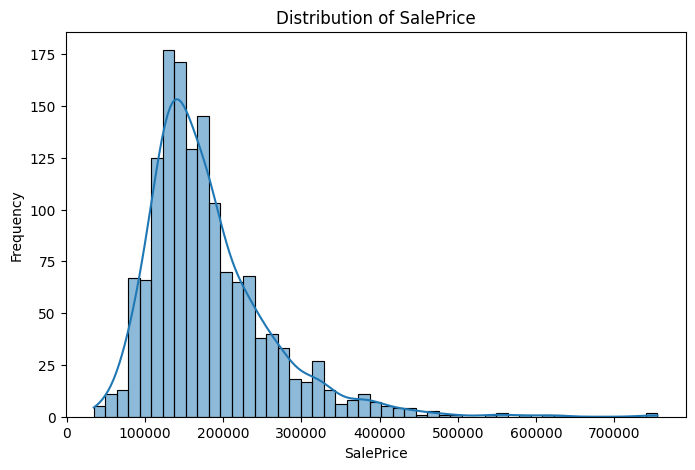

In [77]:
plt.figure(figsize=(8, 5))
sns.histplot(traindf['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

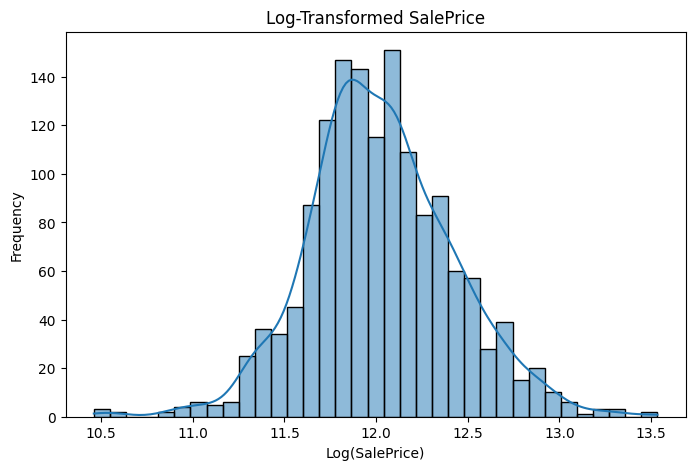

In [78]:
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(traindf['SalePrice']), kde=True)
plt.title('Log-Transformed SalePrice')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')
plt.show()

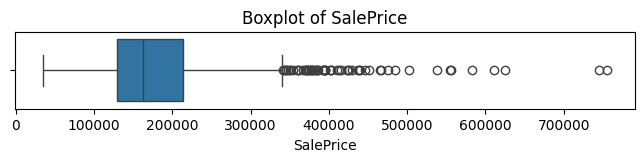

In [79]:
plt.figure(figsize=(8, 1))
sns.boxplot(x=traindf['SalePrice'])
plt.title('Boxplot of SalePrice')
plt.show()

After an initial look at our target variable **SalePrice** we can see a right-skewed distribution.  
This is to be expected as most houses will sell around the same price with the more expensive ones being fewer in number.

## 2. Missing Values Analysis & Handling

### 2.1 Missing values on training dataset

Now lets look at which features have missing values and how many each have.

In [80]:
traindf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


As per the data_description.txt file, many of these features use NA as intented value, meaning "None".  
But there are other variables where that is not the case, like **GarageYrBlt** or **MasVnrArea**.  

As there are not that many features, lets explore them manually and deal with them accordingly.

**PoolQC** is a categorical variable which describes the quality of the pool, NA is not one of the categories but given that there is no category for "No pool", those 1453 missing values should mean that those 1453 houses have no pool.  

We can confirm this looking at how many houses have 0 pool area and checking if those entries are the same as the ones with **PoolQC** missing values.

In [81]:
(traindf['PoolArea'] == 0).sum()

np.int64(1453)

In [82]:
traindf[(traindf['PoolArea'] == 0) & (traindf['PoolQC'].isnull())].shape

(1453, 81)

Now lets transform empty values into a string "None" to avoid issues with missing values downstream.

In [83]:
traindf['PoolQC'] = traindf['PoolQC'].fillna('None')
traindf['PoolQC'].unique()

array(['None', 'Ex', 'Fa', 'Gd'], dtype=object)

**MiscFeature** is also a categorical variable with NA as intended value for None, lets compare it with **MiscVal** which represents the value of said feature.

In [84]:
(traindf['MiscVal'] == 0).sum()

np.int64(1408)

In [85]:
traindf[(traindf['MiscVal'] == 0) & (traindf['MiscFeature'].isnull())].shape

(1406, 81)

There seems to be 2 instances of **MiscVal** 0 more than the number of entries with **MiscFeature** as NA.  

In [86]:
traindf[(traindf['MiscVal'] == 0) & (traindf['MiscFeature'].notna())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
873,874,40,RL,60.0,12144,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1949,1950,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,CBlock,TA,TA,No,Rec,375,Unf,0,457,832,GasA,Gd,Y,SBrkr,1036,0,232,1268,0,0,1,0,3,1,TA,6,Typ,1,Gd,Attchd,1949.0,Unf,1,288,TA,TA,Y,0,28,0,0,0,0,None,NaN,Othr,0,9,2009,WD,Normal,133000
1200,1201,20,RL,71.0,9353,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,864,864,GasA,Gd,Y,SBrkr,864,0,0,864,0,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1972.0,Unf,1,280,TA,TA,Y,0,0,0,0,0,0,None,NaN,Shed,0,7,2006,Oth,Abnorml,116050


As there are only 2 entries, we will drop them and replace the NA values of the rest of **MiscFeature** with "None".

In [87]:
traindf = traindf.drop(index=traindf[(traindf['MiscVal'] == 0) & (traindf['MiscFeature'].notna())].index)

In [88]:
traindf['MiscFeature'] = traindf['MiscFeature'].fillna('None')
traindf['MiscFeature'].unique()

array(['None', 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

Both **Alley** and **Fence** also use NA as None. This time there is no information to crosscheck, so we will assume all NA values are correct.

In [89]:
traindf['Alley'] = traindf['Alley'].fillna('None')
traindf['Alley'].unique()

array(['None', 'Grvl', 'Pave'], dtype=object)

In [90]:
traindf['Fence'] = traindf['Fence'].fillna('None')
traindf['Fence'].unique()

array(['None', 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

**MasVnrType** is a categorical variable that describes the type of masonry veneer, and **MasVnrArea** is a numerical variable that measures its area in square feet.  
For the type there is a None category but with None instead of NA. Lets check its values:

In [91]:
(traindf['MasVnrArea'] == 0).sum()

np.int64(859)

In [92]:
traindf['MasVnrArea'].isnull().sum()

np.int64(8)

In [93]:
traindf['MasVnrType'].isnull().sum()

np.int64(870)

There seems to be some type of inconsistency here, as we have 870 missing values on **MasVnrType**, 8 missing values on **MasVnrArea**, and 859 values of 0 area.  
We should first check which rows have unexpected values.

In [94]:
traindf[(traindf['MasVnrArea'] > 0) & (traindf['MasVnrType'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
624,625,60,RL,80.0,10400,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,6,5,1972,1972,Gable,CompShg,VinylSd,VinylSd,NaN,288.0,TA,TA,CBlock,TA,TA,No,Rec,247,Unf,0,485,732,GasA,Gd,Y,SBrkr,1012,778,0,1790,1,0,1,2,4,1,TA,8,Min2,1,TA,Attchd,1972.0,RFn,2,484,TA,TA,Y,148,0,0,0,147,0,None,None,None,0,11,2006,WD,Normal,165150
773,774,20,RL,70.0,10150,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,5,1958,1958,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,1.0,TA,TA,CBlock,TA,TA,No,Rec,456,Unf,0,456,912,GasA,Ex,Y,FuseA,912,0,0,912,0,0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1958.0,RFn,1,275,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,7,2007,COD,Normal,114500
1230,1231,90,RL,NaN,18890,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,RRAe,Duplex,1.5Fin,5,5,1977,1977,Shed,CompShg,Plywood,Plywood,NaN,1.0,TA,TA,CBlock,Gd,TA,No,GLQ,498,Rec,211,652,1361,GasA,Ex,Y,SBrkr,1361,1259,0,2620,0,0,2,2,4,2,TA,12,Typ,1,TA,BuiltIn,1977.0,RFn,2,600,TA,TA,N,155,24,145,0,0,0,None,None,Gar2,8300,8,2007,WD,Normal,190000
1300,1301,60,RL,NaN,10762,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,1999,1999,Gable,CompShg,VinylSd,VinylSd,NaN,344.0,Gd,TA,PConc,Gd,TA,No,GLQ,694,Unf,0,284,978,GasA,Ex,Y,SBrkr,1005,978,0,1983,0,0,2,1,3,1,Gd,9,Typ,1,TA,Attchd,1999.0,Fin,2,490,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,5,2009,WD,Normal,225000
1334,1335,160,RM,24.0,2368,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,TwnhsE,2Story,5,6,1970,1970,Gable,CompShg,HdBoard,HdBoard,NaN,312.0,TA,TA,CBlock,TA,TA,No,LwQ,765,Unf,0,0,765,GasA,TA,Y,SBrkr,765,600,0,1365,0,0,1,1,3,1,TA,7,Min1,0,NaN,Attchd,1970.0,Unf,2,440,TA,TA,Y,0,36,0,0,0,0,None,None,None,0,5,2009,WD,Normal,125000


In [95]:
traindf[(traindf['MasVnrArea'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,235,60,RL,NaN,7851,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,None,None,None,0,5,2010,WD,Normal,216500
529,530,20,RL,NaN,32668,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,None,None,None,0,3,2007,WD,Alloca,200624
650,651,60,FV,65.0,8125,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal,205950
936,937,20,RL,67.0,10083,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833,Unf,0,343,1176,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,2003.0,RFn,2,555,TA,TA,Y,0,41,0,0,0,0,None,None,None,0,8,2009,WD,Normal,184900
973,974,20,FV,95.0,11639,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1428,1428,GasA,Ex,Y,SBrkr,1428,0,0,1428,0,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2007.0,Fin,2,480,TA,TA,Y,0,120,0,0,0,0,None,None,None,0,12,2008,New,Partial,182000
977,978,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106,Unf,0,135,1241,GasA,Ex,Y,SBrkr,1241,0,0,1241,1,0,1,1,1,1,Gd,4,Typ,0,NaN,Attchd,2007.0,Fin,2,569,TA,TA,Y,0,116,0,0,0,0,None,None,None,0,11,2007,New,Partial,199900
1243,1244,20,RL,107.0,13891,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386,Unf,0,690,2076,GasA,Ex,Y,SBrkr,2076,0,0,2076,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3,850,TA,TA,Y,216,229,0,0,0,0,None,None,None,0,9,2006,New,Partial,465000
1278,1279,60,RL,75.0,9473,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,804,Unf,0,324,1128,GasA,Ex,Y,SBrkr,1128,903,0,2031,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2,577,TA,TA,Y,0,211,0,0,0,0,None,None,None,0,3,2008,WD,Normal,237000


In [96]:
traindf[(traindf['MasVnrArea'] == 0) & ~(traindf['MasVnrType'].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
688,689,20,RL,60.0,8089,Pave,None,Reg,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,8,6,2007,2007,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,945,Unf,0,474,1419,GasA,Ex,Y,SBrkr,1419,0,0,1419,1,0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2007.0,RFn,2,567,TA,TA,Y,140,0,0,0,0,0,None,None,None,0,10,2007,New,Partial,392000
1241,1242,20,RL,83.0,9849,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,6,2007,2007,Hip,CompShg,VinylSd,VinylSd,Stone,0.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1689,1689,GasA,Ex,Y,SBrkr,1689,0,0,1689,0,0,2,0,3,1,Gd,7,Typ,0,NaN,Attchd,2007.0,RFn,3,954,TA,TA,Y,0,56,0,0,0,0,None,None,None,0,6,2007,New,Partial,248328


We can see 4 different cases here:  
> 8 entries where both type and area are NA  
> 2 entries where type is NA but where the area is 1.0, which would not make sense as that area value is too small  
> 3 entries where type is NA but where the area has a reasonable value  
> 2 entries where there is a valid type but the area is 0  

We are going to drop the entries with both values missing, and the two with 1.0 as area, because they are only 10 entries (<1% of the total).  

As for the other two cases, we are going to replace the missing values with the mode of the type from its neighborhood, and with the median of the neighborhood of the area.

In [97]:
traindf = traindf.drop(index=traindf[(traindf['MasVnrType'].isnull()) & (traindf['MasVnrArea'].isnull())].index)
traindf = traindf.drop(index=traindf[(traindf['MasVnrArea'] == 1.0)].index)

In [98]:
# Create boolean mask for those rows where MasVnrType is NaN and MasVnrArea is not 0
mask1 = traindf['MasVnrType'].isna() & (traindf['MasVnrArea'] != 0)

# Create boolean mask for those rows where MasVnrType has a valid value and MasVnrArea is 0
mask2 = ~traindf['MasVnrType'].isna() & (traindf['MasVnrArea'] == 0)

# Group by Neighborhood and get the mode of MasVnrType by Neighborhood and the median of MasVnrArea.
MasVnrType_mode_Neighborhood = (traindf.groupby('Neighborhood')['MasVnrType'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
MasVnrArea_median_Neighborhood = traindf.groupby('Neighborhood')['MasVnrArea'].median()

# Map the mode values to the original DataFrame
traindf.loc[mask1, 'MasVnrType'] = traindf.loc[mask1, 'Neighborhood'].map(MasVnrType_mode_Neighborhood)
traindf.loc[mask2, 'MasVnrArea'] = traindf.loc[mask2, 'Neighborhood'].map(MasVnrArea_median_Neighborhood)

Lets check whether all the missing values remaining matches the number of properties without masonry veneer.

In [99]:
print(traindf['MasVnrType'].isnull().sum())
print((traindf['MasVnrArea'] == 0).sum())
traindf[(traindf['MasVnrArea'] == 0) & ~(traindf['MasVnrType'].isnull())]

857
858


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
688,689,20,RL,60.0,8089,Pave,None,Reg,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,8,6,2007,2007,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,945,Unf,0,474,1419,GasA,Ex,Y,SBrkr,1419,0,0,1419,1,0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2007.0,RFn,2,567,TA,TA,Y,140,0,0,0,0,0,None,None,None,0,10,2007,New,Partial,392000


We can see there is still an entry with valid veneer type but area 0, this means that the median of that neighborhood is 0.  
As it is only one entry, our safest approach is to just drop this one entry.

In [100]:
traindf = traindf.drop(index=traindf[(traindf['MasVnrArea'] == 0) & ~(traindf['MasVnrType'].isnull())].index)

Now we will replace the NA values in type by 'None'.

In [101]:
traindf['MasVnrType'] = traindf['MasVnrType'].fillna('None')
traindf['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn'], dtype=object)

**FireplaceQu** has NA as None, and the amount should match the amount of 0 **Fireplaces**.  
If so, we will just replace those NA with "None".

In [102]:
(traindf['FireplaceQu'].isnull()).sum()

np.int64(684)

In [103]:
(traindf['Fireplaces'] == 0).sum()

np.int64(684)

In [104]:
traindf[(traindf['Fireplaces'] == 0) & (traindf['FireplaceQu'].isnull())].shape

(684, 81)

In [105]:
traindf['FireplaceQu'] = traindf['FireplaceQu'].fillna('None')
traindf['FireplaceQu'].unique()

array(['None', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

**LotFrontage** shows the linear feet of street connected to the house.  
As there is a big number of missing values (~17%), dropping them would not be reasonable.  
Instead, we will replace those values by the median of the neighborhood.

In [106]:
# Create boolean mask for those rows where LotFrontage is NA.
mask = traindf['LotFrontage'].isna()

# Group by Neighborhood and get the mode of LotFrontage by Neighborhood
LotFrontage_median_Neighborhood = traindf.groupby('Neighborhood')['LotFrontage'].median()

# Map the mode values to the original DataFrame
traindf.loc[mask, 'LotFrontage'] = traindf.loc[mask, 'Neighborhood'].map(LotFrontage_median_Neighborhood)

In [107]:
(traindf['LotFrontage'].isnull()).sum()

np.int64(0)

Now we will check the garage related variables.
We have 81 missing values on **GarageQual, GarageType, GarageFinish, GarageYrBlt, GarageExposure**.  
All those are categorical and have NA as legitimate value for "no garage", except **GarageYrBlt** which is numerical (year the garage was built).  

Besides those, we can see two more variables related to the garage, **GarageArea** and **GarageCars** which are numerical variables.

Now we should check that those 81 missing values on each feature, they all match 81 unique entries, that at the same time should have all of them 0 in both Area and Cars.

In [108]:
(traindf['GarageCars'] == 0).sum()

np.int64(81)

In [109]:
(traindf['GarageArea'] == 0).sum()

np.int64(81)

In [110]:
traindf[(traindf['GarageArea'] == 0) & (traindf['GarageCars'] == 0) & (traindf['GarageQual'].isnull()) 
        & (traindf['GarageType'].isnull()) & (traindf['GarageFinish'].isnull()) 
        & (traindf['GarageCond'].isnull()) & (traindf['GarageYrBlt'].isnull())].shape

(81, 81)

After checking this we can safely replace NA values on the categorical variables with "None", and for **GarageYrBlt** we will replace with -1 as a placeholder to indicate there is no garage.

In [111]:
for var in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    traindf[var] = traindf[var].fillna('None')
    print(f"Unique values in {var}: {traindf[var].unique()}")
traindf['GarageYrBlt'] = traindf['GarageYrBlt'].fillna(-1)
(traindf['GarageYrBlt'] == -1).sum()

Unique values in GarageType: ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'None' 'Basment' '2Types']
Unique values in GarageFinish: ['RFn' 'Unf' 'Fin' 'None']
Unique values in GarageQual: ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
Unique values in GarageCond: ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']


np.int64(81)

As far as basement related variables, we have 11 in total:
> **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2**, these 5 categorical features use NA as value for "no basement", and those are the ones that show missing values.  
> **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF**, these 4 numerical features describe the area in square feet of the different sections of the basement, they have no missing values.  
> **BsmtFullBath, BsmtHalfBath**, these 2 numerical features describe the amount of full and half bathrooms that there are in the basement, they have no missing values.  

We expect to see that those entries with missing values in all 5 categorical features, should have 0 as value in all the numerical variables.  
First we will check that and replace the missing values with "None" and then we can focus in the rest of the missing values.

In [112]:
BsmtCatCols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
mask = traindf[BsmtCatCols].isnull().all(axis=1)

print("Basement 1 area: ", 
      traindf[mask]["BsmtFinSF1"].value_counts())

print("Basement 2 area: ", 
      traindf[mask]["BsmtFinSF2"].value_counts())

print("Unfinished basement area: ", 
      traindf[mask]["BsmtUnfSF"].value_counts())

print("Basement total area: ", 
      traindf[mask]["TotalBsmtSF"].value_counts())

print("Basement full bathrooms: ", 
      traindf[mask]["BsmtFullBath"].value_counts())

print("Basement half bathrooms: ", 
      traindf[mask]["BsmtHalfBath"].value_counts())

Basement 1 area:  BsmtFinSF1
0    37
Name: count, dtype: int64
Basement 2 area:  BsmtFinSF2
0    37
Name: count, dtype: int64
Unfinished basement area:  BsmtUnfSF
0    37
Name: count, dtype: int64
Basement total area:  TotalBsmtSF
0    37
Name: count, dtype: int64
Basement full bathrooms:  BsmtFullBath
0    37
Name: count, dtype: int64
Basement half bathrooms:  BsmtHalfBath
0    37
Name: count, dtype: int64


With that we can safely replace in those 37 entries the missing value with "None".

In [113]:
traindf.loc[mask, BsmtCatCols] = traindf.loc[mask, BsmtCatCols].fillna('None')

Lets check what missing values remain.

In [114]:
traindf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

BsmtExposure    1
BsmtFinType2    1
Electrical      1
dtype: int64

In [115]:
traindf[traindf["BsmtExposure"].isnull() | traindf["BsmtFinType2"].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
332,333,20,RL,85.0,10655,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,296.0,Gd,TA,PConc,Gd,TA,No,GLQ,1124,NaN,479,1603,3206,GasA,Ex,Y,SBrkr,1629,0,0,1629,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2003.0,RFn,3,880,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,10,2009,WD,Normal,284000
948,949,60,RL,65.0,14006,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0,Unf,0,936,936,GasA,Ex,Y,SBrkr,936,840,0,1776,0,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2002.0,RFn,2,474,TA,TA,Y,144,96,0,0,0,0,None,None,None,0,2,2006,WD,Normal,192500


We can see that there is one entry with **BsmtFinType2** empty even though there is surface area and the other values make sense, and another entry where **BsmtExposure**'s value is missing even though the rest of the values indicate that there is an unfinished basement. Both cases seem to be missing information, not empty on purpose.  

Given that it is only 2 entries, we will drop them.

In [116]:
traindf = traindf.drop(index=traindf[traindf["BsmtExposure"].isnull() | traindf["BsmtFinType2"].isnull()].index)

As for the entry with the **Electrical** feature missing, we will drop it too.

In [117]:
traindf = traindf.drop(index=traindf[traindf["Electrical"].isnull()].index)

Before we proceed lets check all missing values have been dealt with:

In [118]:
traindf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

Series([], dtype: int64)

An empty list means there are no more missing values in our data.

In [119]:
traindf.shape

(1444, 81)

We have lost in total 16 rows (~1%), but now we have a clean dataset that will not give us problems when we implement any models that cannot deal with missing values natively.

Lets save the cleaned dataset into a CSV file before proceeding with the next steps.

In [120]:
train_clean_output_path = '../data/processed/train_clean.csv'  # Output file path
traindf.to_csv(train_clean_output_path, index=False)

### 2.2 Missing values on test dataset

Now we will repeat the same operations with the test dataset provided, but without dropping any rows as we will need to make a prediction from all of them.  

We will start by loading the test set.

In [121]:
rawtestdata_path = '../data/raw/test.csv' # Path to the test dataset
testdf = pd.read_csv(rawtestdata_path)

In [122]:
testdf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageFinish      78
GarageQual        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Exterior2nd        1
dtype: int64

We have more features with missing values in the test dataset than in the train set, but most seem to be one or two entries.  

As we cannot drop rows on the test set given that we need to make a prediction for all of them, lets first apply carefully the same transformations as with the training set and see what remains.

In [123]:
# Replace NA with 'None' in every missing PoolQC that has PoolArea = 0
mask = (testdf["PoolArea"] == 0) & (testdf["PoolQC"].isnull())
testdf.loc[mask, "PoolQC"] = 'None'

# Replace NA with 'None' in every missing MiscFeature that has MiscVal = 0
mask = (testdf["MiscVal"] == 0) & (testdf["MiscFeature"].isnull())
testdf.loc[mask, "MiscFeature"] = 'None'

# Replace NA with 'None' in every missing Alley and Fence
testdf['Alley'] = testdf['Alley'].fillna('None')
testdf['Fence'] = testdf['Fence'].fillna('None')

# For those with both MasVnrtype and MasVnrArea missing, we will first replace the area with the median of the neighborhood from the training set
mask = testdf['MasVnrType'].isna() & (testdf['MasVnrArea'].isna())
testdf.loc[mask, 'MasVnrArea'] = testdf.loc[mask, 'Neighborhood'].map(MasVnrArea_median_Neighborhood)
# Then replace the MasVnrType with the mode of the neighborhood from the training set on those rows with a valid MasVnrArea (>0)
mask = testdf['MasVnrType'].isna() & (testdf['MasVnrArea'] > 0)
testdf.loc[mask, 'MasVnrType'] = testdf.loc[mask, 'Neighborhood'].map(MasVnrType_mode_Neighborhood)
# And for those with MasVnrArea = 0 and MasVnrType missing, we will replace the type with 'None'
mask = testdf['MasVnrType'].isna() & (testdf['MasVnrArea'] == 0)
testdf.loc[mask, "MasVnrType"] = 'None'

# Replace NA with 'None' in every missing FireplaceQu that has Fireplaces = 0
mask = (testdf["Fireplaces"] == 0) & (testdf["FireplaceQu"].isnull())
testdf.loc[mask, "FireplaceQu"] = 'None'

# Replace NA with the median LotFrontage of the neighborhood from the training set
mask = testdf['LotFrontage'].isna()
testdf.loc[mask, 'LotFrontage'] = testdf.loc[mask, 'Neighborhood'].map(LotFrontage_median_Neighborhood)

# Replace NA with 'None' in every missing categorical Garage variables, with -1 in GarageYrBlt and with 0 in GarageArea and GarageCars
# But only for those entries where all Garage variables mean there is no garage
mask = (
    ((testdf['GarageArea'].isnull()) | (testdf['GarageArea'] == 0)) &
    ((testdf['GarageCars'].isnull()) | (testdf['GarageCars'] == 0)) &
    (testdf['GarageQual'].isnull()) &
    (testdf['GarageType'].isnull()) &
    (testdf['GarageFinish'].isnull()) &
    (testdf['GarageCond'].isnull()) &
    ((testdf['GarageYrBlt'].isnull()) | (testdf['GarageYrBlt'] == 0))
)

for var in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    testdf.loc[mask, var] = 'None'
testdf.loc[mask, 'GarageYrBlt'] = -1
testdf.loc[mask, 'GarageArea'] = 0
testdf.loc[mask, 'GarageCars'] = 0



# Replace NA with 'None' in every missing categorical Basement variables, and with 0 in the numerical ones
# But only for those entries where all Basement variables mean there is no basement
mask = (
    ((testdf['BsmtFinSF1'].isnull()) | (testdf['BsmtFinSF1'] == 0)) &
    ((testdf['BsmtFinSF2'].isnull()) | (testdf['BsmtFinSF2'] == 0)) &
    ((testdf['BsmtUnfSF'].isnull()) | (testdf['BsmtUnfSF'] == 0)) &
    ((testdf['TotalBsmtSF'].isnull()) | (testdf['TotalBsmtSF'] == 0)) &
    ((testdf['BsmtFullBath'].isnull()) | (testdf['BsmtFullBath'] == 0)) &
    ((testdf['BsmtHalfBath'].isnull()) | (testdf['BsmtHalfBath'] == 0)) &
    (testdf['BsmtQual'].isnull()) &
    (testdf['BsmtCond'].isnull()) &
    (testdf['BsmtExposure'].isnull()) &
    (testdf['BsmtFinType1'].isnull()) &
    (testdf['BsmtFinType2'].isnull())
)
for var in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    testdf.loc[mask, var] = 'None'
for var in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    testdf.loc[mask, var] = 0

Afther that transformation the missing values remaining are the following.

In [124]:
testdf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

MSZoning        4
BsmtCond        3
PoolQC          3
Utilities       2
BsmtQual        2
BsmtExposure    2
GarageFinish    2
GarageQual      2
GarageCond      2
Functional      2
GarageYrBlt     2
GarageArea      1
Exterior1st     1
KitchenQual     1
GarageCars      1
Exterior2nd     1
MiscFeature     1
SaleType        1
dtype: int64

In [125]:
testdf.isnull().any(axis=1).sum()

np.int64(22)

Most missing values have been cleaned, but there are a few remnants over 22 entries that we will deal with manually.  

Using the information provided in data_description.txt we will proceed with the following:

- **MSZoning** we will replace missing values with the mode by neighborhood from the training set
- **PoolQC** we will replace missing values with the mode by neighborhood from the training set (we previously already replaced those with 0 **PoolArea** by "None")
- **Utilities** we will replace missing values with the mode by neighborhood from the training set
- **Functional** we will replace missing values with "Typ" (From documentation: Assume typical unless deductions are warranted)
- **Exterior1st** we will replace missing values with the mode by neighborhood from the training set
- **Exterior2nd** we will replace missing values with the mode by neighborhood from the training set
- **KitchenQual** we will replace missing values with the mode by neighborhood from the training set
- **MiscFeature** we will replace missing values with "Other" category (we previously already replaced those with 0 **MiscVal** by "None)
- **SaleType** we will replace missing values with the mode by neighborhood from the training set

In [126]:
mask = testdf['MSZoning'].isna()
MSZoning_mode_Neighborhood = (traindf.groupby('Neighborhood')['MSZoning'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'MSZoning'] = testdf.loc[mask, 'Neighborhood'].map(MSZoning_mode_Neighborhood)

mask = testdf['PoolQC'].isna()
PoolQC_mode_Neighborhood = (traindf.groupby('Neighborhood')['PoolQC'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'PoolQC'] = testdf.loc[mask, 'Neighborhood'].map(PoolQC_mode_Neighborhood)

mask = testdf['Utilities'].isna()
Utilities_mode_Neighborhood = (traindf.groupby('Neighborhood')['Utilities'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'Utilities'] = testdf.loc[mask, 'Neighborhood'].map(Utilities_mode_Neighborhood)

mask = testdf['Functional'].isna()
testdf.loc[mask, 'Functional'] = "Typ"

mask = testdf['Exterior1st'].isna()
Exterior1st_mode_Neighborhood = (traindf.groupby('Neighborhood')['Exterior1st'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'Exterior1st'] = testdf.loc[mask, 'Neighborhood'].map(Exterior1st_mode_Neighborhood)

mask = testdf['Exterior2nd'].isna()
Exterior2nd_mode_Neighborhood = (traindf.groupby('Neighborhood')['Exterior2nd'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'Exterior2nd'] = testdf.loc[mask, 'Neighborhood'].map(Exterior2nd_mode_Neighborhood)

mask = testdf['KitchenQual'].isna()
KitchenQual_mode_Neighborhood = (traindf.groupby('Neighborhood')['KitchenQual'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'KitchenQual'] = testdf.loc[mask, 'Neighborhood'].map(KitchenQual_mode_Neighborhood)

mask = testdf['MiscFeature'].isna()
testdf.loc[mask, 'MiscFeature'] = "Other"

mask = testdf['SaleType'].isna()
SaleType_mode_Neighborhood = (traindf.groupby('Neighborhood')['SaleType'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
testdf.loc[mask, 'SaleType'] = testdf.loc[mask, 'Neighborhood'].map(SaleType_mode_Neighborhood)

We should have left the Basement and Garage related variables.

In [127]:
testdf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

BsmtCond        3
GarageFinish    2
GarageYrBlt     2
GarageQual      2
BsmtQual        2
BsmtExposure    2
GarageCond      2
GarageArea      1
GarageCars      1
dtype: int64

In [128]:
testdf.isnull().any(axis=1).sum()

np.int64(9)

They are only 9 entries, lets explore them:

In [129]:
testdf[testdf.isnull().any(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
27,1488,20,RL,73.0,8987,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,226.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,GasA,Ex,Y,SBrkr,1595,0,0,1595,0.0,0.0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2005.0,RFn,3.0,880.0,TA,TA,Y,144,0,0,0,0,0,None,None,None,0,5,2010,WD,Normal
580,2041,20,RL,103.0,16280,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,8,9,1976,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Ex,Ex,CBlock,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,GasA,Ex,Y,SBrkr,1671,0,0,1671,1.0,0.0,3,0,3,1,Ex,6,Typ,1,Gd,Attchd,1976.0,RFn,2.0,550.0,TA,TA,Y,280,90,0,0,0,0,None,GdWo,None,0,5,2008,WD,Normal
666,2127,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,None,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,0,None,MnPrv,Shed,1000,9,2008,WD,Normal
725,2186,20,RL,65.0,6500,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,6,6,1976,1976,Hip,CompShg,HdBoard,Plywood,BrkFace,84.0,TA,TA,CBlock,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,GasA,TA,Y,SBrkr,1127,0,0,1127,0.0,1.0,1,1,3,1,TA,6,Typ,1,Po,Detchd,1991.0,Unf,2.0,480.0,TA,TA,Y,0,0,138,0,0,0,None,None,None,0,5,2008,WD,Normal
757,2218,70,C (all),60.0,5280,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,7,1895,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,Stone,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,GasA,Ex,N,SBrkr,825,536,0,1361,0.0,0.0,1,0,2,1,TA,6,Typ,0,None,Detchd,1895.0,Unf,1.0,185.0,Fa,TA,Y,0,123,0,0,0,0,None,None,None,0,7,2008,WD,Normal
758,2219,50,C (all),52.0,5150,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,1.5Fin,4,7,1910,2000,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,PConc,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,GasA,TA,N,FuseA,671,378,0,1049,0.0,0.0,1,0,2,1,TA,5,Typ,0,None,Detchd,1910.0,Unf,1.0,195.0,Po,Fa,N,0,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal
888,2349,60,FV,81.0,10411,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,2Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,CBlock,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,GasA,Ex,Y,SBrkr,725,863,0,1588,0.0,0.0,3,0,3,1,Gd,8,Typ,0,None,Attchd,2007.0,Unf,2.0,561.0,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,7,2007,New,Partial
1064,2525,80,RL,72.0,9720,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SLvl,5,7,1977,1977,Gable,CompShg,Plywood,VinylSd,BrkFace,51.0,TA,TA,CBlock,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,GasA,TA,Y,SBrkr,1009,0,0,1009,0.0,0.0,2,0,3,1,TA,6,Typ,1,Fa,Detchd,1977.0,Unf,2.0,576.0,TA,TA,Y,0,0,0,0,0,0,None,MnPrv,None,0,6,2007,WD,Normal
1116,2577,70,RM,50.0,9060,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,None,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,None,MnPrv,None,0,3,2007,WD,Alloca


We can see there is one entry where even though there is **GarageType** defined, the rest of the information related to the garage is missing, so we are going to assume there is no garage on the property and the type was a data error.  

The rest of the entries show enough information about basement and garage, so we will replace the missing parts using the mode by neighborhood on the categorical variables and the median on the numerical ones.

In [130]:
# First lets deal with the row where we are assuming there is no garage
row_label = testdf[testdf["GarageCars"].isnull()].index[0]
# Now lets change the rest of the garage variables
for var in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    testdf.loc[row_label, var] = 'None'
testdf.loc[row_label, "GarageArea"] = 0.0
testdf.loc[row_label, "GarageCars"] = 0.0
testdf.loc[row_label, "GarageYrBlt"] = -1

# Now for the rest, lets replace the missing values of the categorical variables with the mode of the neighborhood from the training set
for var in ['GarageFinish', 'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtQual', 'BsmtCond']:
    mask = testdf[var].isna()
    mode = (traindf.groupby('Neighborhood')[var].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None'))
    testdf.loc[mask, var] = testdf.loc[mask, 'Neighborhood'].map(mode)

# And for GarageYrBlt, the only numerical variable, we will replace it with the median of the neighborhood from the training set
GarageYrBlt_median_Neighborhood = traindf.groupby('Neighborhood')['GarageYrBlt'].median()
row_label = testdf[testdf["GarageYrBlt"].isnull()].index[0]
neighborhood = testdf.loc[row_label, 'Neighborhood']
testdf.loc[row_label, 'GarageYrBlt'] = GarageYrBlt_median_Neighborhood[neighborhood]

Let's do a final check to make sure all missing values have been dealt with:

In [131]:
testdf.isnull().sum().sort_values(ascending=False)[lambda x: x > 0]

Series([], dtype: int64)

And now lets save the cleaned test dataset to a file.

In [132]:
test_clean_output_path = '../data/processed/test_clean.csv'  # Output file path
testdf.to_csv(test_clean_output_path, index=False)

# 3. Feature engineering  

Given the information available, there are a few features that could provide useful information for our prediction task.  

We are going to create the following on both sets of data:
- **TotalBathrooms**: Including basement ones
- **TotalSF**: Both floors plus basement
- **FinishedSF**: Total livable area (excluding unfinished basement)
- **Has2ndFloor**: Yes/No
- **HasBasement**: Yes/No
- **HasGarage**: Yes/No
- **HasPool**: Yes/No
- **HouseAge**: Years from when it was build till last sale
- **RemodelAge**: Years from last remodelation till last sale
- **WasRemodeled**: Yes/No
- **QualityIndex**: Ratio expressing overall quality and condition
- **LotRatio**: Ratio expressing relative house to land size (area)

In [133]:
traindf["TotalBathrooms"] = traindf["FullBath"] + (0.5 * traindf["HalfBath"]) + traindf["BsmtFullBath"] + (0.5 * traindf["BsmtHalfBath"])
testdf["TotalBathrooms"] = testdf["FullBath"] + (0.5 * testdf["HalfBath"]) + testdf["BsmtFullBath"] + (0.5 * testdf["BsmtHalfBath"])

traindf["TotalSF"] = traindf["TotalBsmtSF"] + traindf["1stFlrSF"] + traindf["2ndFlrSF"]
testdf["TotalSF"] = testdf["TotalBsmtSF"] + testdf["1stFlrSF"] + testdf["2ndFlrSF"]

traindf["FinishedSF"] = traindf["BsmtFinSF1"] + traindf["BsmtFinSF2"] + traindf["1stFlrSF"] + traindf["2ndFlrSF"]
testdf["FinishedSF"] = testdf["BsmtFinSF1"] + testdf["BsmtFinSF2"] + testdf["1stFlrSF"] + testdf["2ndFlrSF"]

traindf["Has2ndFloor"] = (traindf["2ndFlrSF"] > 0).astype(int)
testdf["Has2ndFloor"] = (testdf["2ndFlrSF"] > 0).astype(int)

traindf["HasBasement"] = (traindf["TotalBsmtSF"] > 0).astype(int)
testdf["HasBasement"] = (testdf["TotalBsmtSF"] > 0).astype(int)

traindf["HasGarage"] = (traindf["GarageArea"] > 0).astype(int)
testdf["HasGarage"] = (testdf["GarageArea"] > 0).astype(int)

traindf["HasPool"] = (traindf["PoolArea"] > 0).astype(int)
testdf["HasPool"] = (testdf["PoolArea"] > 0).astype(int)

traindf["HouseAge"] = traindf["YrSold"] - traindf["YearBuilt"]
testdf["HouseAge"] = testdf["YrSold"] - testdf["YearBuilt"]

traindf["RemodelAge"] = traindf["YrSold"] - traindf["YearRemodAdd"]
testdf["RemodelAge"] = testdf["YrSold"] - testdf["YearRemodAdd"]

traindf["WasRemodel"] = (traindf["YearRemodAdd"] != traindf["YearBuilt"]).astype(int)
testdf["WasRemodel"] = (testdf["YearRemodAdd"] != testdf["YearBuilt"]).astype(int)

traindf["QualityIndex"] = traindf["OverallQual"] * traindf["OverallCond"]
testdf["QualityIndex"] = testdf["OverallQual"] * testdf["OverallCond"]

traindf["LotRatio"] = traindf["GrLivArea"] / traindf["LotArea"]
testdf["LotRatio"] = testdf["GrLivArea"] / testdf["LotArea"]

Besides this, we will drop the **Id** column in both datasets, as it offers no useful information for this task.

In [134]:
traindf.drop('Id', axis=1, inplace=True)
testdf.drop('Id', axis=1, inplace=True)

And lets save both engineered datasets.

In [135]:
train_eng_output_path = '../data/processed/train_engineered.csv'  # Output file path
traindf.to_csv(train_eng_output_path, index=False)

test_eng_output_path = '../data/processed/test_engineered.csv'  # Output file path
testdf.to_csv(test_eng_output_path, index=False)

# 4. Preprocessing for modeling

## 4.1 Log-transform target variable

Let's transform our target variable **SalePrice** 

In [136]:
traindf["SalePrice"] = np.log1p(traindf["SalePrice"])

## 4.2 Data split for validation

Our training dataset is relatively small, and the test set has already been split beforehand.  

As such, we will split our training set with a 70/30 split for validation purposes.

In [137]:
Y = traindf["SalePrice"]
X = traindf.drop("SalePrice", axis=1)

In [138]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.3, random_state=33)

## 4.3 Categorical variables encoding

Even though TFDF Random Forest model handles internally the encoding, we are going to manually encode there features in order to make a baseline model first

We need to separate categorical from numerical features first.

In [142]:
cat_features = ['MSSubClass', 'MSZoning',  'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond',  'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 
       'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive',  'PoolQC', 'Fence', 'MiscFeature', 
       'SaleType', 'SaleCondition',  'Has2ndFloor', 'HasBasement', 'HasGarage',
       'HasPool', 'WasRemodel']

num_features = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
        'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'TotalBathrooms',
        'TotalSF', 'FinishedSF', 'HouseAge', 'RemodelAge', 'QualityIndex', 'LotRatio']

And now we will use Scikit-Learn to encode the categorical features leaving the numerical ones as they are.

In [144]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        # numerical columns are passed through unchanged
        ('num', 'passthrough', num_features)
    ]
)

# 5. Baseline model

We will use Scikit-Learn to build a simple linear model.  

In this case we will use Ridge Regression instead of linear regression due to the high number of features (the regularization could help avoid overfitting).

We will leave the alpha parameter as default (1.0) as this model is just a baseline.

In [170]:
Ridge_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", Ridge(alpha=1.0))
])

In [193]:
# Fit the model
Ridge_model.fit(X_train, Y_train)

# Predict on dev set
Y_pred = Ridge_model.predict(X_dev)

In [194]:
Ridge_rmse_log = root_mean_squared_error(Y_dev, Y_pred)
Ridge_rmse = root_mean_squared_error(np.expm1(Y_dev), np.expm1(Y_pred))
print(f"Ridge RMSE (log scale): {Ridge_rmse_log:.4f}")
print(f"Ridge RMSE (original scale): {np.expm1(Ridge_rmse_log):.4f}")
print(f"Random Forest RMSE (dollars): {Ridge_rmse:.4f}")

Ridge RMSE (log scale): 0.1469
Ridge RMSE (original scale): 0.1582
Random Forest RMSE (dollars): 32955.2568


Our baseline Ridge Regression model got a 15.82% on RMSE.

# 6. Random Forest

We will use TensorFLow Decision Forests to build our Random Forest model.  

TFDF can handle internally the encoding of categorical features, and as such we will be using the cleaned and engineered datasets directly with no preprocessing.

In [ ]:
RF_model = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.REGRESSION,        # Define the task (Regression)
    num_trees=300,                          # Number of trees in the forest
    max_depth=10,                           # Maximum depth of trees
    min_examples=5,                         # Minimum number of examples per leaf node
    categorical_algorithm="CART",           # Algorithm for handling categorical features
    compute_oob_variable_importances=True,  # Compute out-of-bag variable importances
)

2025-05-13 18:58:18.027250: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Use /tmp/tmpmu6ot24m as temporary training directory


In [174]:
RF_model.fit(tfdf.keras.pd_dataframe_to_tf_dataset(
    pd.concat([X_train, Y_train], axis=1), 
    task=tfdf.keras.Task.REGRESSION, label="SalePrice"))

Reading training dataset...
Training dataset read in 0:00:03.709498. Found 1010 examples.
Training model...


I0000 00:00:1747155509.833665  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747155509.837571  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747155509.837878  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747155509.846423  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747155509.847675  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747155509.852168  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747155509.852498  976838 data_spec_inference.cc:354] 2 item(s) have been prun

Model trained in 0:00:02.763628
Compiling model...


I0000 00:00:1747155512.560695  976838 decision_forest.cc:808] Model loaded with 300 root(s), 74056 node(s), and 89 input feature(s).
I0000 00:00:1747155512.564083  976838 abstract_model.cc:1439] Engine "RandomForestOptPred" built
2025-05-13 18:58:32.564698: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.


Lets check the out-of-bag performance metrics.

In [176]:
RF_inspector = RF_model.make_inspector()
print(RF_inspector.evaluation())

Evaluation(num_examples=1010, accuracy=None, loss=None, rmse=0.1350284390505362, ndcg=None, aucs=None, auuc=None, qini=None)


And finally lets make the predictions with the dev set and evaluate how our model performed.

In [189]:
Y_pred = RF_model.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_dev))

1/1 [==============================] - 0s 205ms/step


In [192]:

RF_rmse_log = root_mean_squared_error(Y_dev, Y_pred)
RF_rmse = root_mean_squared_error(np.expm1(Y_dev), np.expm1(Y_pred))

print(f"Random Forest RMSE (log scale): {RF_rmse_log:.4f}")
print(f"Random Forest RMSE (original scale): {np.expm1(RF_rmse_log):.4f}")
print(f"Random Forest RMSE (dollars): {RF_rmse:.4f}")

Random Forest RMSE (log scale): 0.1312
Random Forest RMSE (original scale): 0.1402
Random Forest RMSE (dollars): 28698.3330


There is a substantial improvement already over our baseline model, but let's finetune it and see if it can be improved further.

In [198]:
def evaluate_rf_model(num_trees, max_depth, min_examples):
    RF_model = tfdf.keras.RandomForestModel(
        task=tfdf.keras.Task.REGRESSION,             # Define the task (Regression)
        num_trees=num_trees,                         # Number of trees in the forest
        max_depth=max_depth,                         # Maximum depth of trees
        min_examples=min_examples,                   # Minimum number of examples per leaf node
        categorical_algorithm="CART",
        compute_oob_variable_importances=False,      # Compute out-of-bag variable importances
    )

    # Fit the model to the training data
    RF_model.fit(tfdf.keras.pd_dataframe_to_tf_dataset(
        pd.concat([X_train, Y_train], axis=1), 
        task=tfdf.keras.Task.REGRESSION, label="SalePrice"), verbose=0)

    # Predict on dev set
    Y_pred = RF_model.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_dev))
    rmse = root_mean_squared_error(Y_dev, Y_pred)
    return rmse

In [ ]:
RF_tuning = []

for trees in [100, 300, 500]:
    for depth in [8, 10, 12]:
        for minex in [2, 5, 10]:
            # Evaluate model and get RMSE
            rmse = evaluate_rf_model(trees, depth, minex)
            
            # Append the results to the list
            RF_tuning.append({
                "num_trees": trees,
                "max_depth": depth,
                "min_examples": minex,
                "rmse": rmse
            })

RF_tuning_df = pd.DataFrame(RF_tuning)
RF_tuning_df = RF_tuning_df.sort_values(by="rmse")

Use /tmp/tmppdmds6_s as temporary training directory


I0000 00:00:1747160633.400641  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160633.400689  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160633.400716  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160633.400982  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160633.400993  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160633.402439  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160633.402485  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 162ms/step
Use /tmp/tmpseq96g8y as temporary training directory


I0000 00:00:1747160638.629294  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160638.629364  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160638.629388  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160638.629788  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160638.629812  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160638.631777  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160638.631894  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 186ms/step
Use /tmp/tmpjlazftc0 as temporary training directory


I0000 00:00:1747160641.244965  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160641.245029  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160641.245045  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160641.245276  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160641.245284  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160641.246720  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160641.246772  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 171ms/step
Use /tmp/tmpnur76j9i as temporary training directory


I0000 00:00:1747160644.001607  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160644.001657  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160644.001684  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160644.001938  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160644.001945  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160644.004448  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160644.004533  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 157ms/step
Use /tmp/tmpbf046rn0 as temporary training directory


I0000 00:00:1747160646.699288  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160646.699344  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160646.699366  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160646.699670  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160646.699686  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160646.701271  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160646.701328  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 154ms/step
Use /tmp/tmpj21tyi5e as temporary training directory


I0000 00:00:1747160649.426376  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160649.426420  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160649.426433  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160649.426691  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160649.426698  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160649.428061  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160649.428107  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 176ms/step
Use /tmp/tmpm5rn8aio as temporary training directory


I0000 00:00:1747160651.970948  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160651.970994  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160651.971005  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160651.971209  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160651.971216  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160651.972618  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160651.972666  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 164ms/step
Use /tmp/tmpm9dja5tc as temporary training directory


I0000 00:00:1747160654.691331  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160654.691375  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160654.691400  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160654.691667  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160654.691674  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160654.693340  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160654.693401  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 152ms/step
Use /tmp/tmp0us16jqs as temporary training directory


I0000 00:00:1747160657.212882  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160657.212967  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160657.212992  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160657.213245  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160657.213252  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160657.214923  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160657.215073  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 149ms/step
Use /tmp/tmp1k76t7vl as temporary training directory


I0000 00:00:1747160659.840331  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160659.840377  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160659.840388  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160659.840604  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160659.840613  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160659.841997  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160659.842044  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 170ms/step
Use /tmp/tmpro9p8qil as temporary training directory


I0000 00:00:1747160662.766673  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160662.766727  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160662.766739  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160662.766968  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160662.766976  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160662.768443  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160662.768490  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 157ms/step
Use /tmp/tmps9e3zbxk as temporary training directory


I0000 00:00:1747160665.510548  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160665.510595  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160665.510606  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160665.510878  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160665.510888  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160665.512295  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160665.512341  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 161ms/step
Use /tmp/tmpyq6n9hw4 as temporary training directory


I0000 00:00:1747160668.266571  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160668.266623  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160668.266637  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160668.266882  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160668.266890  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160668.268272  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160668.268319  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 163ms/step
Use /tmp/tmp0hq3tvkd as temporary training directory


I0000 00:00:1747160672.291759  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160672.291811  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160672.291823  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160672.292191  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160672.292202  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160672.293727  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160672.293783  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 161ms/step
Use /tmp/tmp8z5i65ib as temporary training directory


I0000 00:00:1747160677.017537  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160677.020650  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160677.020708  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160677.035199  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160677.035262  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160677.050326  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160677.050435  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 169ms/step
Use /tmp/tmp4ht4hccs as temporary training directory


I0000 00:00:1747160680.328477  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160680.328535  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160680.328569  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160680.328855  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160680.328865  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160680.330354  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160680.330428  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 168ms/step
Use /tmp/tmpn87087hx as temporary training directory


I0000 00:00:1747160684.522209  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160684.522284  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160684.522309  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160684.522582  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160684.522595  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160684.524094  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160684.524178  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 162ms/step
Use /tmp/tmpac59evcl as temporary training directory


I0000 00:00:1747160687.790505  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160687.790573  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160687.790586  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160687.790811  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160687.790818  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160687.792440  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160687.792525  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 176ms/step
Use /tmp/tmpicq6i1hs as temporary training directory


I0000 00:00:1747160690.836097  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160690.836192  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160690.836217  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160690.836496  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160690.836503  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160690.837989  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160690.838049  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 172ms/step
Use /tmp/tmp0h28_k_s as temporary training directory


I0000 00:00:1747160694.508720  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160694.508769  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160694.508780  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160694.509115  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160694.509123  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160694.510633  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160694.510746  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 195ms/step
Use /tmp/tmpe2pvjni1 as temporary training directory


I0000 00:00:1747160697.643911  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160697.643963  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160697.643976  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160697.644265  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160697.644276  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160697.645925  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160697.645970  976838 data_spec_inference.cc:354] 2 item(s) have been prun

1/1 [==============================] - 0s 160ms/step
Use /tmp/tmpvvlusprz as temporary training directory


I0000 00:00:1747160700.683362  976838 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1747160700.683408  976838 kernel.cc:783] Collect training examples
I0000 00:00:1747160700.683433  976838 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1747160700.683665  976838 kernel.cc:401] Number of batches: 2
I0000 00:00:1747160700.683684  976838 kernel.cc:402] Number of examples: 1010
I0000 00:00:1747160700.685318  976838 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1747160700.685387  976838 data_spec_inference.cc:354] 2 item(s) have been prun

In [ ]:
print(RF_tuning_df)

(to be done next)

# 7. MLP model
(enconding, scaling, normalizing)
# 8. TabNet model
# 9. Models comparison
# 10. Chosen model test prediction
and inverse transformation of predictions np.expm1()